In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from tqdm.notebook import tqdm

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-03-05 22:02:39.954423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 22:02:39.954561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 22:02:40.081504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
captions_file_path = '/kaggle/input/flickr8k/captions.txt'
with open(captions_file_path, 'r') as file:
    lines = file.readlines()

captions_dict = {}
for line in lines:
    image_id, caption = line.strip().split(',', 1)
    captions_dict.setdefault(image_id,[] ).append(caption)


In [4]:
df = pd.DataFrame(list(captions_dict.items()), columns=['images_id', 'captions'])
df = df.iloc[1:]
df

images_id  \
1     1000268201_693b08cb0e.jpg   
2     1001773457_577c3a7d70.jpg   
3     1002674143_1b742ab4b8.jpg   
4     1003163366_44323f5815.jpg   
5     1007129816_e794419615.jpg   
...                         ...   
8087   990890291_afc72be141.jpg   
8088    99171998_7cc800ceef.jpg   
8089    99679241_adc853a5c0.jpg   
8090   997338199_7343367d7f.jpg   
8091   997722733_0cb5439472.jpg   

                                               captions  
1     [A child in a pink dress is climbing up a set ...  
2     [A black dog and a spotted dog are fighting, A...  
3     [A little girl covered in paint sits in front ...  
4     [A man lays on a bench while his dog sits by h...  
5     [A man in an orange hat starring at something ...  
...                                                 ...  
8087  [A man does a wheelie on his bicycle on the si...  
8088  [A group is sitting around a snowy crevasse .,...  
8089  [A grey bird stands majestically on a beach wh...  
8090  [A person stands near golden walls ., a woman ...  
8091  [A man in a pink shirt climbs a rock face, A m...  

[8091 rows x 2 columns]

In [5]:
captions_file_path = '/kaggle/input/flickr8k/captions.txt'
with open(captions_file_path, 'r') as file:
    lines = file.readlines()

captions_dict = {}
for line in lines:
    image_id, caption = line.strip().split(',', 1)
    captions_dict.setdefault(image_id, []).append(caption)

# Remove square brackets from the captions
for image_id, captions in captions_dict.items():
    captions_dict[image_id] = [caption.strip('[]') for caption in captions]

# Now, captions_dict contains captions without square brackets
# df = pd.DataFrame(list(captions_dict.items()), columns=['Images_id', 'captions'])

df


images_id  \
1     1000268201_693b08cb0e.jpg   
2     1001773457_577c3a7d70.jpg   
3     1002674143_1b742ab4b8.jpg   
4     1003163366_44323f5815.jpg   
5     1007129816_e794419615.jpg   
...                         ...   
8087   990890291_afc72be141.jpg   
8088    99171998_7cc800ceef.jpg   
8089    99679241_adc853a5c0.jpg   
8090   997338199_7343367d7f.jpg   
8091   997722733_0cb5439472.jpg   

                                               captions  
1     [A child in a pink dress is climbing up a set ...  
2     [A black dog and a spotted dog are fighting, A...  
3     [A little girl covered in paint sits in front ...  
4     [A man lays on a bench while his dog sits by h...  
5     [A man in an orange hat starring at something ...  
...                                                 ...  
8087  [A man does a wheelie on his bicycle on the si...  
8088  [A group is sitting around a snowy crevasse .,...  
8089  [A grey bird stands majestically on a beach wh...  
8090  [A person stands near golden walls ., a woman ...  
8091  [A man in a pink shirt climbs a rock face, A m...  

[8091 rows x 2 columns]

In [6]:
#caption_dict is the dictionary where each umage id is mapped with its list of captions
captions_dict['1000268201_693b08cb0e.jpg']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
df


images_id  \
1     1000268201_693b08cb0e.jpg   
2     1001773457_577c3a7d70.jpg   
3     1002674143_1b742ab4b8.jpg   
4     1003163366_44323f5815.jpg   
5     1007129816_e794419615.jpg   
...                         ...   
8087   990890291_afc72be141.jpg   
8088    99171998_7cc800ceef.jpg   
8089    99679241_adc853a5c0.jpg   
8090   997338199_7343367d7f.jpg   
8091   997722733_0cb5439472.jpg   

                                               captions  
1     [A child in a pink dress is climbing up a set ...  
2     [A black dog and a spotted dog are fighting, A...  
3     [A little girl covered in paint sits in front ...  
4     [A man lays on a bench while his dog sits by h...  
5     [A man in an orange hat starring at something ...  
...                                                 ...  
8087  [A man does a wheelie on his bicycle on the si...  
8088  [A group is sitting around a snowy crevasse .,...  
8089  [A grey bird stands majestically on a beach wh...  
8090  [A person stands near golden walls ., a woman ...  
8091  [A man in a pink shirt climbs a rock face, A m...  

[8091 rows x 2 columns]

In [8]:
image_vectors = []

In [9]:
for i in df['images_id'][0:2]:
    image_path = "/kaggle/input/flickr8k/Images/" + i
    img = cv2.imread(image_path)
    image_vectors.append(img)

In [10]:
image_vectors

[array([[[ 77,  56,  58],
         [130, 131, 115],
         [117, 123, 106],
         ...,
         [  2,   4,   4],
         [  2,   4,   4],
         [  4,   6,   6]],
 
        [[ 73,  55,  56],
         [126, 132, 115],
         [117, 123, 106],
         ...,
         [  5,   5,   5],
         [ 13,  17,  12],
         [  2,   8,   3]],
 
        [[ 69,  51,  52],
         [123, 130, 115],
         [119, 125, 108],
         ...,
         [  6,  11,  10],
         [  6,   9,   7],
         [  3,   4,   2]],
 
        ...,
 
        [[ 11,  78, 193],
         [ 41, 154, 221],
         [116, 244, 243],
         ...,
         [204, 185, 170],
         [205, 184, 169],
         [193, 185, 168]],
 
        [[ 31,  88, 187],
         [137, 239, 252],
         [ 99, 196, 255],
         ...,
         [202, 186, 170],
         [203, 184, 169],
         [193, 184, 170]],
 
        [[ 25, 100, 200],
         [ 26, 106, 199],
         [  6,  66, 166],
         ...,
         [201, 186, 170],
  

In [11]:
image_vectors[1]

array([[[108, 103, 102],
        [101,  96,  95],
        [105, 100,  99],
        ...,
        [ 21,  29,  29],
        [ 23,  28,  31],
        [ 22,  25,  30]],

       [[114, 109, 108],
        [106, 101, 100],
        [100,  95,  94],
        ...,
        [ 29,  37,  37],
        [ 29,  34,  37],
        [ 25,  28,  33]],

       [[120, 112, 112],
        [126, 118, 118],
        [108, 100, 100],
        ...,
        [ 32,  40,  40],
        [ 29,  34,  37],
        [ 26,  31,  34]],

       ...,

       [[114, 101, 103],
        [110,  98, 104],
        [127, 114, 122],
        ...,
        [ 94,  88,  83],
        [ 89,  83,  76],
        [ 85,  79,  72]],

       [[121, 114, 111],
        [ 97,  88,  91],
        [ 86,  78,  85],
        ...,
        [106, 100,  95],
        [ 90,  84,  79],
        [ 90,  84,  79]],

       [[101,  96,  93],
        [ 73,  66,  69],
        [109, 101, 111],
        ...,
        [ 98,  91,  88],
        [ 92,  85,  82],
        [105,  99,  94]]

In [12]:
import matplotlib.pyplot as plt

In [13]:
df['images_id'][1]

'1000268201_693b08cb0e.jpg'

In [14]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


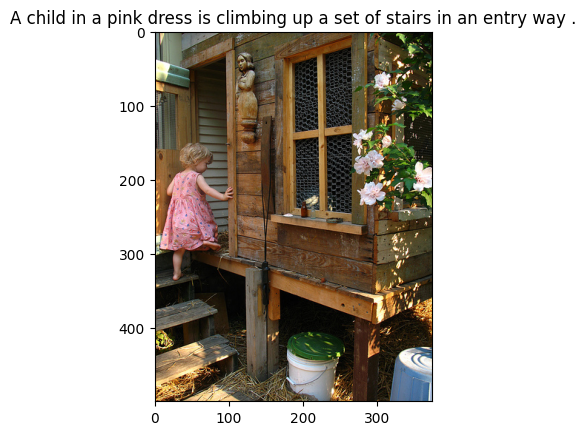

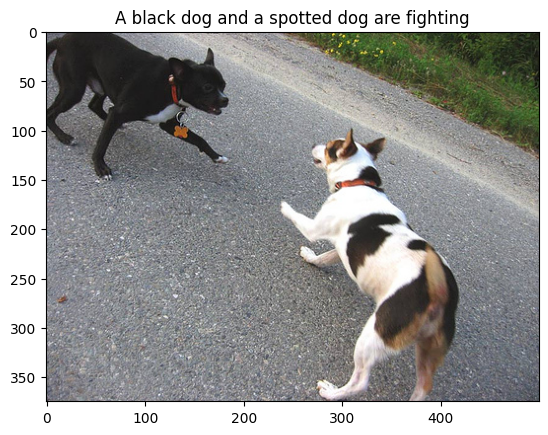

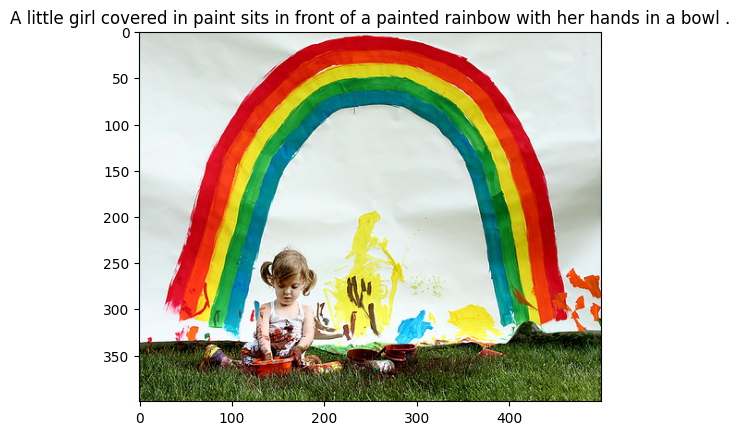

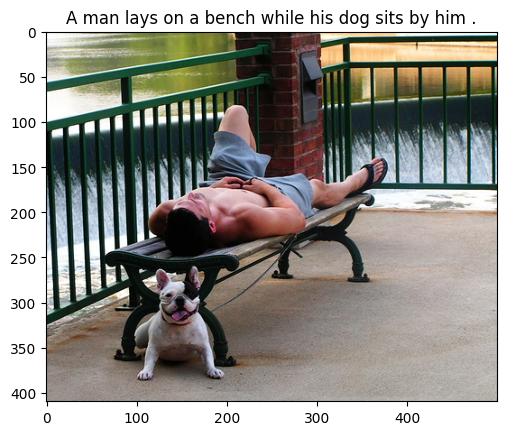

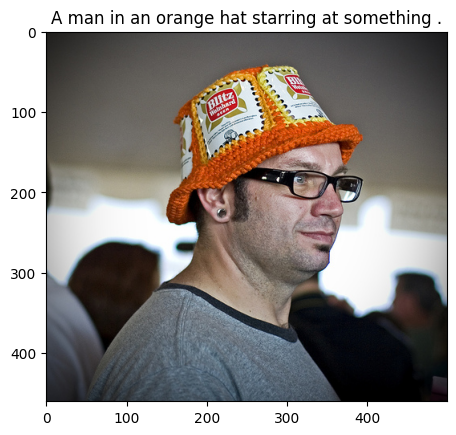

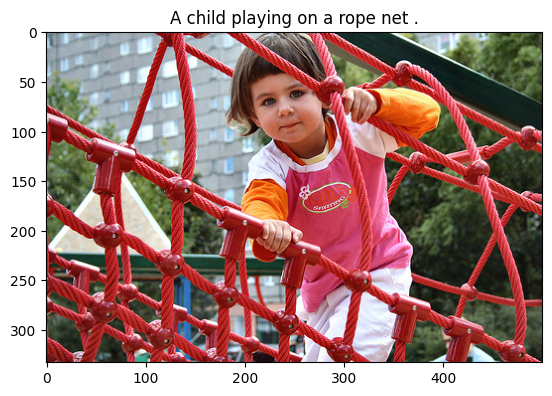

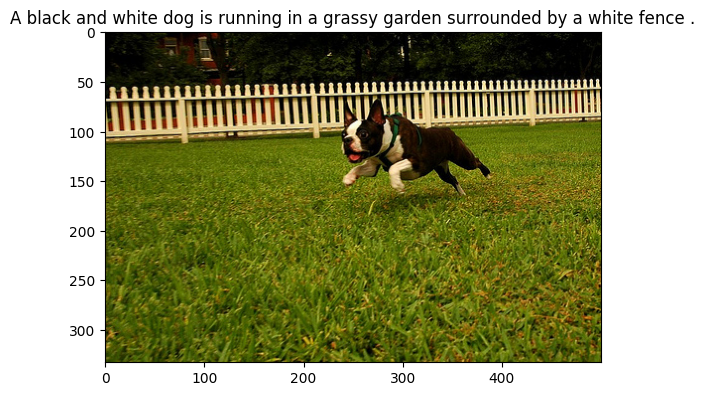

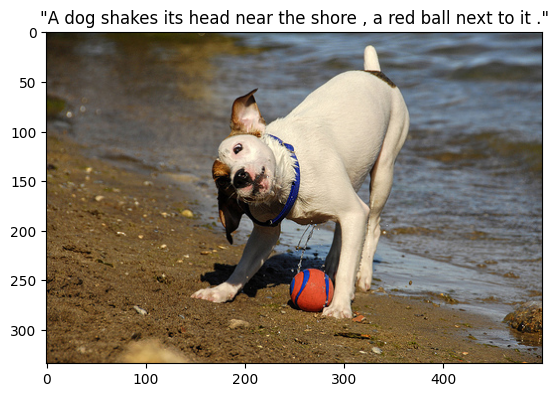

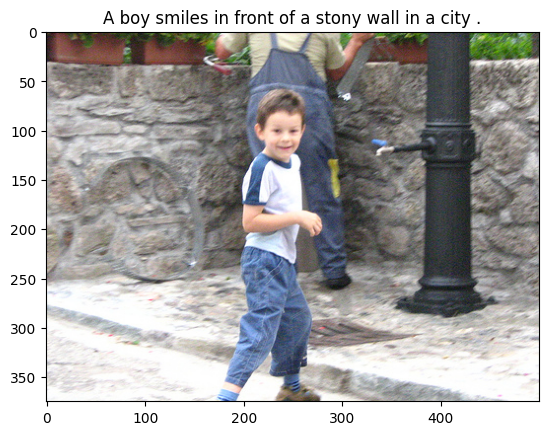

In [15]:
for i in range(1,10):
    img_path = "/kaggle/input/flickr8k/Images/" + df['images_id'][i]
    im = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(df['captions'][i][0])
    plt.show()

In [16]:
inception_v3 = InceptionV3()
inception_v3 = Model(inputs = inception_v3.inputs, outputs = inception_v3.layers[-2].output)
inception_v3.summary()

96112376/96112376 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [17]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img/255
    return img 

def get_feature_vector(img_path):
    img = load_img(img_path)
    img = tf.expand_dims(img, axis=0)
    feature_vector = inception_v3(img)
    feature_vector = np.array(feature_vector)
    return feature_vector


In [18]:
type(get_feature_vector("/kaggle/input/flickr8k/Images/" + df['images_id'][1]))

numpy.ndarray

In [19]:
# extract features from image
features = {}
directory = os.path.join('/kaggle/input/flickr8k/', 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    feature = get_feature_vector(img_path)
    features[img_name] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [20]:
features['1012212859_01547e3f17.jpg']

array([[3.0429283e-01, 7.4556249e-01, 1.4240783e-01, ..., 7.1754934e-05,
        2.8701594e-01, 4.6680325e-01]], dtype=float32)

In [21]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
            captions[i] = caption

In [22]:
clean(captions_dict)

In [23]:
captions_dict['1000268201_693b08cb0e.jpg']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [24]:
all_captions = []
for key in captions_dict:
    for caption in captions_dict[key]:
        all_captions.append(caption)

In [25]:
len(all_captions)

40456

In [26]:
all_captions[:10]

['<start> caption <end>',
 '<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>']

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
vocab_size

8484

In [29]:
df

images_id  \
1     1000268201_693b08cb0e.jpg   
2     1001773457_577c3a7d70.jpg   
3     1002674143_1b742ab4b8.jpg   
4     1003163366_44323f5815.jpg   
5     1007129816_e794419615.jpg   
...                         ...   
8087   990890291_afc72be141.jpg   
8088    99171998_7cc800ceef.jpg   
8089    99679241_adc853a5c0.jpg   
8090   997338199_7343367d7f.jpg   
8091   997722733_0cb5439472.jpg   

                                               captions  
1     [A child in a pink dress is climbing up a set ...  
2     [A black dog and a spotted dog are fighting, A...  
3     [A little girl covered in paint sits in front ...  
4     [A man lays on a bench while his dog sits by h...  
5     [A man in an orange hat starring at something ...  
...                                                 ...  
8087  [A man does a wheelie on his bicycle on the si...  
8088  [A group is sitting around a snowy crevasse .,...  
8089  [A grey bird stands majestically on a beach wh...  
8090  [A person stands near golden walls ., a woman ...  
8091  [A man in a pink shirt climbs a rock face, A m...  

[8091 rows x 2 columns]

In [30]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [31]:
image_ids = []
for i in df['images_id']:
        image_ids.append(i)

In [32]:
image_ids[:10]

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg']

In [33]:
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [34]:
features['1000268201_693b08cb0e.jpg']

array([[0.11288077, 0.16421889, 0.78447825, ..., 0.14073285, 0.33448163,
        0.39008215]], dtype=float32)

In [35]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [36]:

# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


#decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [37]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, captions_dict, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

I0000 00:00:1709677638.464693      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - 40s 178ms/step - loss: 2.2730


In [38]:
model.save('/kaggle/working/' + '/best_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [40]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [41]:
test

['436015762_8d0bae90c3.jpg',
 '436393371_822ee70952.jpg',
 '436608339_f1d1298770.jpg',
 '437054333_5c2761b8cd.jpg',
 '437404867_209625774d.jpg',
 '437527058_189f2a7eef.jpg',
 '437917001_ae1106f34e.jpg',
 '438639005_208bc59b0b.jpg',
 '439037721_cdf1fc7358.jpg',
 '439049388_3dcee2d30b.jpg',
 '439492931_a96d590e40.jpg',
 '439569646_c917f1bc78.jpg',
 '439916996_1ddb9dc8e7.jpg',
 '440184957_267f3f3a2b.jpg',
 '440190907_bf8b7ba8ef.jpg',
 '440737340_5af34ca9cf.jpg',
 '441212506_fcc321ac28.jpg',
 '44129946_9eeb385d77.jpg',
 '441398149_297146e38d.jpg',
 '441817653_fbdf83060b.jpg',
 '441921713_1cafc7d7d2.jpg',
 '442220883_ff3d6e507f.jpg',
 '442594271_2c3dd38483.jpg',
 '442918418_0f29c97fa9.jpg',
 '443430496_3fea95a07d.jpg',
 '443885436_6e927e6c58.jpg',
 '444047125_66b249287c.jpg',
 '444057017_f1e0fcaef7.jpg',
 '444481722_690d0cadcf.jpg',
 '444803340_fdcaab86f9.jpg',
 '444845904_a4531c811a.jpg',
 '444872454_9f51e07f88.jpg',
 '444881000_bba92e585c.jpg',
 '445148321_9f2f3ac711.jpg',
 '445655284_c29

In [42]:
 y_pred = predict_caption(model, features['1000268201_693b08cb0e.jpg'], tokenizer, max_length) 
 y_pred

'<start> man in ponytail is sitting in chair seat at restaurant end end of chair end end end of chair end end end end end end end end end end end end end end end end'